In [7]:
# Print out GPU info
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Not connected to a GPU')
else:
    print(gpu_info)

# Virtual Memory
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

Fri Jun 10 15:39:40 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.73.05    Driver Version: 510.73.05    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:18:00.0 Off |                  N/A |
|123%   83C    P2   189W / 250W |  11001MiB / 11264MiB |     89%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:3B:00.0 Off |                  N/A |
| 27%   

In [1]:
from os.path import join, isdir
from os import listdir, rmdir
from shutil import move, rmtree, make_archive
from collections import namedtuple
import os
import cv2
import glob
import pickle
import numpy as np
import tensorflow as tf

from PIL import Image
import matplotlib.pyplot as plt

# from sklearn.cluster import KMeans

# from keras.optimizers import Adam, SGD
# from keras.callbacks import ModelCheckpoint
# from keras.models import Sequential, Model, load_model
# from keras.layers import Dense, Input, Dropout, Activation, Flatten, BatchNormalization, ReLU, LeakyReLU, concatenate
# from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, AveragePooling2D, GlobalAveragePooling2D, Add

# from google.colab import drive
# drive.mount('/gdrive')
# drive_root = '/gdrive/My Drive/Fall2020/ADL_Final/'

COLAB_DIR = '/home/rohkumar/code/citysacpe/'
GT_DIR = COLAB_DIR + 'gtFine/'
IMG_DIR = COLAB_DIR + 'leftImg8bit/leftImg8bit/'


In [16]:
# collapse child directories
for parent in listdir(GT_DIR):
    parent_dir = GT_DIR + parent
    for child in listdir(parent_dir):
        if isdir(join(parent_dir, child)):
            keep = glob.glob(join(parent_dir, child) + '/*_gtFine_color.png')
            keep = [f.split('/')[-1] for f in keep]
            for filename in list(set(listdir(join(parent_dir, child))) & set(keep)):
                move(join(parent_dir, child, filename), join(parent_dir, filename))
            rmtree(join(parent_dir, child))

for parent in listdir(IMG_DIR):
    parent_dir = IMG_DIR + parent
    for child in listdir(parent_dir):
        if isdir(join(parent_dir, child)):
            for filename in listdir(join(parent_dir, child)):
                move(join(parent_dir, child, filename), join(parent_dir, filename))
            rmtree(join(parent_dir, child))


In [17]:
# process anr archive image in smaller size
IMG_SHAPE = 128, 128

gt_train_paths = [GT_DIR+'train/' + path for path in listdir(GT_DIR+'train/')]
gt_test_paths = [GT_DIR+'test/' + path for path in listdir(GT_DIR+'test/')]
gt_val_paths = [GT_DIR+'val/' + path for path in listdir(GT_DIR+'val/')]
gt_paths = gt_train_paths + gt_test_paths + gt_val_paths

im_train_paths = [IMG_DIR+'train/' + path for path in listdir(IMG_DIR+'train/')]
im_test_paths = [IMG_DIR+'test/' + path for path in listdir(IMG_DIR+'test/')]
im_val_paths = [IMG_DIR+'val/' + path for path in listdir(IMG_DIR+'val/')]
im_paths = im_train_paths + im_test_paths + im_val_paths

def resize_image(path):
    img = Image.open(path)
    img.thumbnail(IMG_SHAPE)
    out_file = join(path)
    img.save(out_file, 'PNG')

for img in gt_paths + im_paths:
    resize_image(img)

make_archive('gtFine1', 'zip', GT_DIR)
make_archive('leftImg1', 'zip', IMG_DIR)

'/home/rohkumar/code/adversarial_attacks_on_segmentation/notebooks/leftImg1.zip'

In [20]:
# normalize image pixels
IMG_SIZE = 128
BATCH_SIZE = 32
AUTOTUNE = tf.data.experimental.AUTOTUNE

GT_DIR = COLAB_DIR + 'gtFine/'
IMG_DIR = COLAB_DIR + 'leftImg8bit/leftImg8bit/'

def load_and_preprocess_image(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
    img /= 255.0
    return img

def get_image_paths(dir):
    return sorted([dir + path for path in listdir(dir)])

# create tf.Dataset objects
gt_train_ds = tf.data.Dataset.from_tensor_slices(get_image_paths(GT_DIR+'train/'))
gt_val_ds = tf.data.Dataset.from_tensor_slices(get_image_paths(GT_DIR+'val/'))
gt_test_ds = tf.data.Dataset.from_tensor_slices(get_image_paths(GT_DIR+'test/'))

gt_train_ds = gt_train_ds.map(load_and_preprocess_image)
gt_val_ds = gt_val_ds.map(load_and_preprocess_image)
gt_test_ds = gt_test_ds.map(load_and_preprocess_image)

im_train_ds = tf.data.Dataset.from_tensor_slices(get_image_paths(IMG_DIR+'train/'))
im_val_ds = tf.data.Dataset.from_tensor_slices(get_image_paths(IMG_DIR+'val/'))
im_test_ds = tf.data.Dataset.from_tensor_slices(get_image_paths(IMG_DIR+'test/'))

im_train_ds = im_train_ds.map(load_and_preprocess_image)
im_val_ds = im_val_ds.map(load_and_preprocess_image)
im_test_ds = im_test_ds.map(load_and_preprocess_image)

In [ ]:

def get_image_paths(dir):
    return sorted([dir + path for path in listdir(dir)])

In [ ]:
def parse_image(img_path: str) -> dict:
    """Load an image and its annotation (mask) and returning
    a dictionary.

    Parameters
    ----------
    img_path : str
        Image (not the mask) location.
        For one Image path:
        .../dataset/images/image1.jpg
        Its corresponding annotation path is:
        .../dataset/masks/masks1.png

    Returns
    -------
    dict
        Dictionary mapping an image and its mask.
    """
    image = tf.io.read_file(img_path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize(image, [128, 128])
    image = tf.image.convert_image_dtype(image, tf.uint8)

    mask_path = tf.strings.regex_replace(img_path, "gtFine_color", "leftImg8bit")
    mask_path = tf.strings.regex_replace(img_path, "gtFine", "leftImg8bit/leftImg8bit")
    print(mask_path)
    mask = tf.io.read_file(mask_path)
    # The masks contain a class index for each pixels
    mask = tf.image.decode_png(mask, channels=1)
    # Since 255 exist, changing it with 0
    mask = tf.where(mask == 255, np.dtype('uint8').type(0), mask)
    return {'image': image, 'segmentation_mask': mask}

In [ ]:
get_image_paths(GT_DIR+'train/')

In [ ]:
def parse_image(img_path: str) -> dict:
    """Load an image and its annotation (mask) and returning
    a dictionary.

    Parameters
    ----------
    img_path : str
        Image (not the mask) location.
        For one Image path:
        .../dataset/images/image1.jpg
        Its corresponding annotation path is:
        .../dataset/masks/masks1.png

    Returns
    -------
    dict
        Dictionary mapping an image and its mask.
    """
    image = tf.io.read_file(img_path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize(image, [128, 128])
    image = tf.image.convert_image_dtype(image, tf.uint8)

    mask_path = tf.strings.regex_replace(img_path, "gtFine_color", "leftImg8bit")
    mask_path = tf.strings.regex_replace(img_path, "gtFine", "leftImg8bit/leftImg8bit")
    print(mask_path)
    mask = tf.io.read_file(mask_path)
    # The masks contain a class index for each pixels
    mask = tf.image.decode_png(mask, channels=1)
    # Since 255 exist, changing it with 0
    mask = tf.where(mask == 255, np.dtype('uint8').type(0), mask)
    return {'image': image, 'segmentation_mask': mask}

In [ ]:
mask_path = tf.strings.regex_replace('/home/rohkumar/code/citysacpe/gtFine/train/aachen_000013_000019_gtFine_color.png', "gtFine_color", "leftImg8bit")
print(mask_path)
mask_path = tf.strings.regex_replace(mask_path, "gtFine", "leftImg8bit/leftImg8bit")
mask_path

In [ ]:
get_image_paths(GT_DIR+'train/')

In [ ]:
gt_train_ds = tf.data.Dataset.from_tensor_slices(get_image_paths(GT_DIR+'train/'))
gt_train_ds = gt_train_ds.map(parse_image)

In [20]:
mask_path = tf.strings.regex_replace('/home/rohkumar/code/citysacpe/gtFine/train/aachen_000013_000019_gtFine_color.png', "gtFine_color", "leftImg8bit")
print(mask_path)
mask_path = tf.strings.regex_replace(mask_path, "gtFine", "leftImg8bit/leftImg8bit")
mask_path

tf.Tensor(b'/home/rohkumar/code/citysacpe/gtFine/train/aachen_000013_000019_leftImg8bit.png', shape=(), dtype=string)


<tf.Tensor: shape=(), dtype=string, numpy=b'/home/rohkumar/code/citysacpe/leftImg8bit/leftImg8bit/train/aachen_000013_000019_leftImg8bit.png'>

In [11]:
get_image_paths(GT_DIR+'train/')

['/home/rohkumar/code/citysacpe/gtFine/train/aachen_000000_000019_gtFine_color.png',
 '/home/rohkumar/code/citysacpe/gtFine/train/aachen_000001_000019_gtFine_color.png',
 '/home/rohkumar/code/citysacpe/gtFine/train/aachen_000002_000019_gtFine_color.png',
 '/home/rohkumar/code/citysacpe/gtFine/train/aachen_000003_000019_gtFine_color.png',
 '/home/rohkumar/code/citysacpe/gtFine/train/aachen_000004_000019_gtFine_color.png',
 '/home/rohkumar/code/citysacpe/gtFine/train/aachen_000005_000019_gtFine_color.png',
 '/home/rohkumar/code/citysacpe/gtFine/train/aachen_000006_000019_gtFine_color.png',
 '/home/rohkumar/code/citysacpe/gtFine/train/aachen_000007_000019_gtFine_color.png',
 '/home/rohkumar/code/citysacpe/gtFine/train/aachen_000008_000019_gtFine_color.png',
 '/home/rohkumar/code/citysacpe/gtFine/train/aachen_000009_000019_gtFine_color.png',
 '/home/rohkumar/code/citysacpe/gtFine/train/aachen_000010_000019_gtFine_color.png',
 '/home/rohkumar/code/citysacpe/gtFine/train/aachen_000011_000019

In [15]:
gt_train_ds = tf.data.Dataset.from_tensor_slices(get_image_paths(GT_DIR+'train/'))
gt_train_ds = gt_train_ds.map(parse_image)

Tensor("StaticRegexReplace_1:0", shape=(), dtype=string)


In [16]:
gt_train_ds

<MapDataset shapes: {image: (128, 128, 3), segmentation_mask: (None, None, 1)}, types: {image: tf.uint8, segmentation_mask: tf.uint8}>

In [22]:
def visualize_images(img, gt, pred):
    if pred is not None:
        fig, axes = plt.subplots(1, 3, figsize=(12, 8))
    else:
        fig, axes = plt.subplots(1, 2, figsize=(8, 8))

    axes[0].imshow(img)
    axes[0].set_title('Actual Image')

    axes[1].imshow(gt)
    axes[1].set_title('Masked Image')
    
    if pred is not None:
        axes[2].imshow(pred)
        axes[2].set_title('Predicted Image')

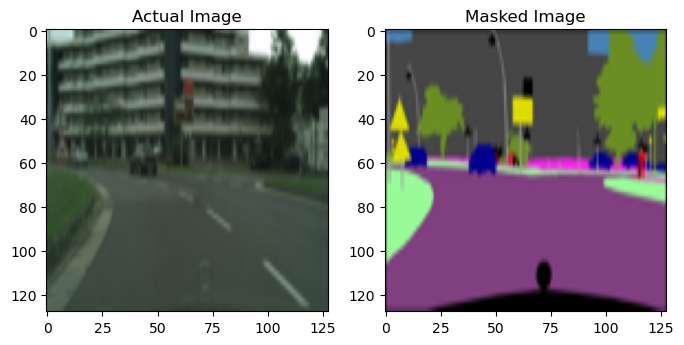

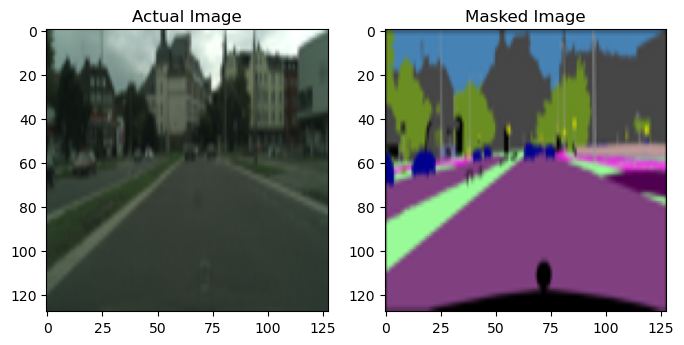

In [25]:
for img, gt in list(zip(im_train_ds.take(2), gt_train_ds.take(2))):
    visualize_images(img, gt, None)
    